In [ ]:
# Install Sastrawi dan MPStemmer
!pip install PySastrawi stanza
!pip install --upgrade git+https://github.com/ariaghora/mpstemmer.git

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Library
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from mpstemmer import MPStemmer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hizbast\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Read Data
df = pd.read_csv('./dataset_sms_spam_v1.csv')
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [4]:
# Melihat apakah ada missing values dari setiap kolom
df.isnull().sum()

Teks     0
label    0
dtype: int64

In [5]:
# Melihat info dari data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [6]:
# Mengubah kategori dari label [0 untuk non-spam, dan 1 untuk spam].
# Label 2 dikategorikan sebagai spam.
df.loc[df['label'] == 2, 'label'] = 1
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1


In [7]:
df['label'].value_counts()

label
1    574
0    569
Name: count, dtype: int64

In [8]:
# Membagi data menjadi features (X) dan label (Y)
X = df['Teks']
Y = df['label']

In [9]:
# Membagi data menjadi data train dan test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 3)

In [10]:
# Membuat cloud word untuk melihat kata apa yang sering digunakan dalam spam
spam_words = ''
non_spam_words = ''

# Membuat korpus yang berisi pesan spam
for val in df[df['label'] == 1].Teks:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '

# Membuat korpus yang berisi pesan non spam
for val in df[df['label'] == 0].Teks:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        non_spam_words = non_spam_words + words + ' '

In [11]:
# Membuat word cloud
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
non_spam_wordcloud = WordCloud(width=500, height=300).generate(non_spam_words)

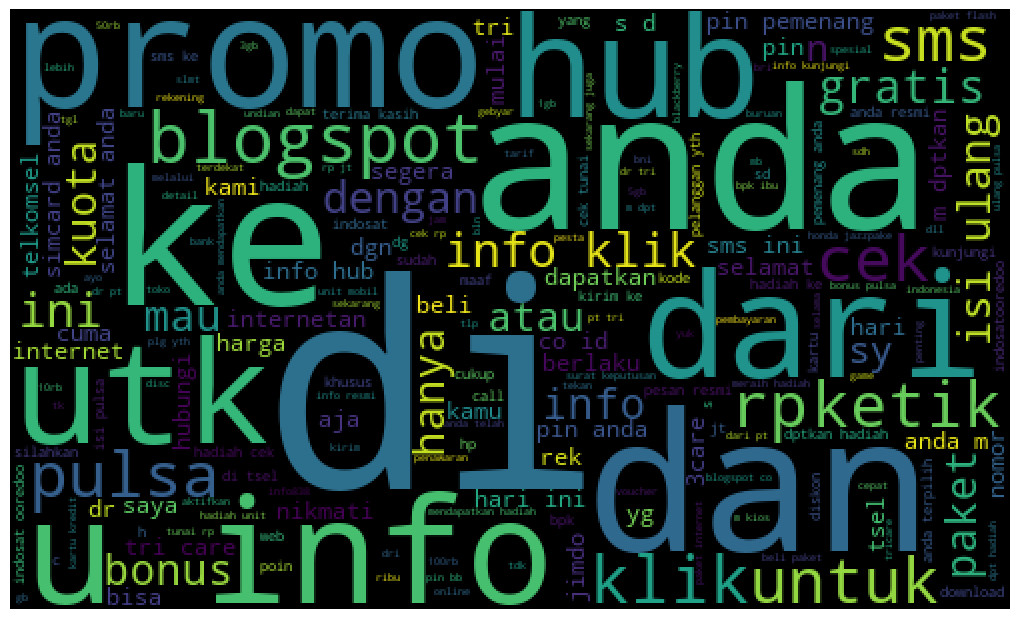

In [12]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Penjelasan:**

Dari word cloud di atas, kita dapat melihat beberapa kata non stop words yang muncul sebagai kata yang sering muncul di pesan spam seperti `promo`, `blogspot`, `cek`, `info`, `klik`, `pulsa`, `gratis`, dsb. Dengan visualisasi word cloud ini, kita dapat mengidentifikasi pesan SPAM dengan lebih mudah kedepannya.

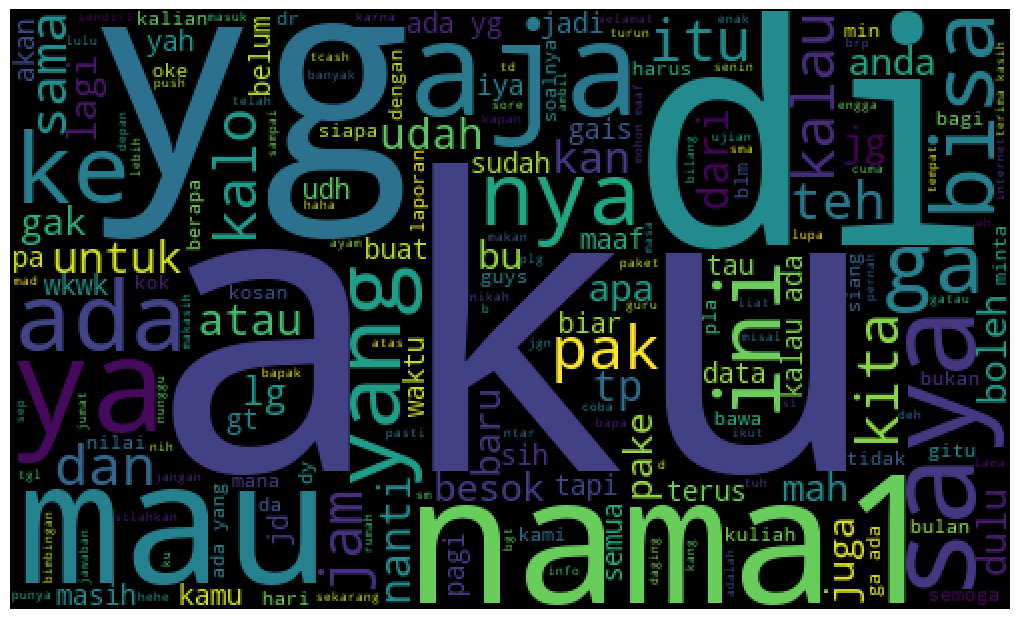

In [13]:
#Non Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(non_spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Penjelasan:**

Dari word cloud di atas, kita dapat melihat beberapa kata non stop words yang muncul sebagai kata non SPAM adalah kata sapaan dan beberapa kata yang sering muncul dalam percakapan sehari-hari. 

In [14]:
# Fungsi untuk melakukan pemrosesan kata agar dapat digunakan
# dalam TF-IDF
def preprocessing(sentence):
    stop_factory = StopWordRemoverFactory()
    stop_words_list = stop_factory.get_stop_words()
    stop_words_set  = set(stop_words_list)
    result = []

    # Regex for tokenization
    tokenizer_pattern = r'\w+'

    # For stemming and lemmatization
    stemmer = MPStemmer()

    # Proses untuk tokenization dan lemmatization
    # dan membuang stopword
    tokens =  re.findall(tokenizer_pattern, sentence)
    for token in tokens:
        token = stemmer.stem(token).lower()
        if token != '' and token != None and token not in stop_words_set:
            result.append(token)
    return result

In [15]:
# Ekstraksi fitur menggunakan TF-IDF
feature_extraction = TfidfVectorizer(tokenizer=preprocessing)

# Ekstraksi fitur untuk train dan test
X_train_features = feature_extraction.fit_transform(X_train)
X_test_features = feature_extraction.transform(X_test)

In [16]:
#Melakukan klasifikasi dengan beberapa model
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=30)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [17]:
#Membuat dictionary yang berisi model
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [18]:
#fit the data onto the models
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [19]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train_features, Y_train)
    pred = predict(v, X_test_features)
    pred_scores_word_vectors.append((k, [accuracy_score(Y_test , pred)]))

In [20]:
pred_scores_word_vectors

[('SVC', [0.9475982532751092]),
 ('KN', [0.8078602620087336]),
 ('NB', [0.8951965065502183]),
 ('DT', [0.8995633187772926]),
 ('LR', [0.8820960698689956]),
 ('RF', [0.9213973799126638])]

In [21]:
# Melakukan optimisasi untuk setiap model
from sklearn.model_selection import GridSearchCV

In [22]:
# Mendefinisikan parameter grid untuk svc
param_grid_svc = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': [0.1, 1.0, 10.0]
}

# Membuat model SVC
svc = SVC()

# Membuat objeck grid search
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy')

# Fit model
grid_search_svc.fit(X_train_features, Y_train)

# Parameter terbaik
best_params_svc = grid_search_svc.best_params_

# Parameter terbaik untuk prediksi
best_svc = grid_search_svc.best_estimator_
svc_predictions = predict(best_svc, X_test_features)
svc_accuracy = accuracy_score(Y_test, svc_predictions)

# Hasil
print(f"Best parameters for SVC: {best_params_svc}")
print(f"Accuracy with the best SVC model: {svc_accuracy}")

Best parameters for SVC: {'gamma': 0.1, 'kernel': 'linear'}
Accuracy with the best SVC model: 0.9475982532751092


Untuk model SVC, ternyata baik menggunakan metode sigmoid dan linear akan menghasilkan akurasi yang sama.

In [23]:
# Parameter grid untuk KNeighborsClassifier
param_grid_knc = {
    'n_neighbors': [5, 10, 15, 20, 25, 30, 35],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Membuat instance dari KNeighborsClassifier
knc = KNeighborsClassifier()

# Membuat objek GridSearchCV
grid_search_knc = GridSearchCV(knc, param_grid_knc, cv=5, scoring='accuracy')

# Melatih model
grid_search_knc.fit(X_train_features, Y_train)

# Mendapatkan parameter terbaik
best_params_knc = grid_search_knc.best_params_

# Menggunakan model terbaik untuk prediksi
best_knc = grid_search_knc.best_estimator_
knc_predictions = predict(best_knc, X_test_features)
knc_accuracy = accuracy_score(Y_test, knc_predictions)

# Menampilkan hasil
print(f"Best parameters for KNC: {best_params_knc}")
print(f"Accuracy with the best KNC model: {knc_accuracy}")

Best parameters for KNC: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
Accuracy with the best KNC model: 0.868995633187773


Dapat dilihat bahwa model KNC mengalami peningkatan dalam akurasi, tetapi nilainya masih dibawah SVC.

In [24]:
# Grid parameter untuk MultinomialNB
param_grid_nb = {
    'alpha': [0.1, 0.2, 0.5, 1.0]
}

# Membuat instance dari MultinomialNB
nb = MultinomialNB()

# Membuat objek GridSearchCV
grid_search_nb = GridSearchCV(nb, param_grid_nb, cv=5, scoring='accuracy')

# Melatih model
grid_search_nb.fit(X_train_features, Y_train)

# Mendapatkan parameter terbaik
best_params_nb = grid_search_nb.best_params_

# Menggunakan model terbaik untuk prediksi
best_nb = grid_search_nb.best_estimator_
nb_predictions = predict(best_nb, X_test_features)
nb_accuracy = accuracy_score(Y_test, nb_predictions)

# Menampilkan hasil
print(f"Best parameters for Multinomial Naive Bayes: {best_params_nb}")
print(f"Accuracy with the best Multinomial Naive Bayes model: {nb_accuracy}")

Best parameters for Multinomial Naive Bayes: {'alpha': 1.0}
Accuracy with the best Multinomial Naive Bayes model: 0.9126637554585153


Dapat dilihat bahwa dengan menggunakan alpha 1.0, ada peningkatan dari akurasi, tetapi belum menyamai model SVC.

In [25]:
# Grid parameter untuk DecisionTreeClassifier
param_grid_dtc = {
    'min_samples_split': [2, 5, 7, 10],
    'criterion': ['gini', 'entropy']
}

# Membuat instance dari DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=111)

# Membuat objek GridSearchCV
grid_search_dtc = GridSearchCV(dtc, param_grid_dtc, cv=5, scoring='accuracy')

# Melatih model
grid_search_dtc.fit(X_train_features, Y_train)

# Mendapatkan parameter terbaik
best_params_dtc = grid_search_dtc.best_params_

# Menggunakan model terbaik untuk prediksi
best_dtc = grid_search_dtc.best_estimator_
dtc_predictions = predict(best_dtc, X_test_features)
dtc_accuracy = accuracy_score(Y_test, dtc_predictions)

# Menampilkan hasil
print(f"Parameter terbaik untuk Decision Tree: {best_params_dtc}")
print(f"Akurasi dengan model Decision Tree terbaik: {dtc_accuracy}")

Parameter terbaik untuk Decision Tree: {'criterion': 'gini', 'min_samples_split': 10}
Akurasi dengan model Decision Tree terbaik: 0.8995633187772926


Dapat dilihat bahwa meskipun sudah dilakukan hyperparameter tuning, model decision tree tidak mengalami peningkatan akurasi.

In [26]:
# Grid parameter untuk LogisticRegression
param_grid_lr = {
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l1', 'l2']
}

# Membuat instance dari LogisticRegression
lr = LogisticRegression(random_state=111)

# Membuat objek GridSearchCV
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy')

# Melatih model
grid_search_lr.fit(X_train_features, Y_train)

# Mendapatkan parameter terbaik
best_params_lr = grid_search_lr.best_params_

# Menggunakan model terbaik untuk prediksi
best_lr = grid_search_lr.best_estimator_
lr_predictions = predict(best_lr, X_test_features)
lr_accuracy = accuracy_score(Y_test, lr_predictions)

# Menampilkan hasil
print(f"Parameter terbaik untuk Logistic Regression: {best_params_lr}")
print(f"Akurasi dengan model Logistic Regression terbaik: {lr_accuracy}")

Parameter terbaik untuk Logistic Regression: {'penalty': 'l2', 'solver': 'liblinear'}
Akurasi dengan model Logistic Regression terbaik: 0.9344978165938864


Dapat dilihat bahwa model Logistc Regression mengalami peningkatan yang cukup baik sesudah tuning, tetapi masih belum sebaik SVC.

In [27]:
# Grid parameter untuk RandomForestClassifier
param_grid_rfc = {
    'n_estimators': [10, 20, 30, 40],
    'criterion': ['gini', 'entropy']
}

# Membuat instance dari RandomForestClassifier
rfc = RandomForestClassifier(random_state=111)

# Membuat objek GridSearchCV
grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv=5, scoring='accuracy')

# Melatih model
grid_search_rfc.fit(X_train_features, Y_train)

# Mendapatkan parameter terbaik
best_params_rfc = grid_search_rfc.best_params_

# Menggunakan model terbaik untuk prediksi
best_rfc = grid_search_rfc.best_estimator_
rfc_predictions = predict(best_rfc, X_test_features)
rfc_accuracy = accuracy_score(Y_test, rfc_predictions)

# Menampilkan hasil
print(f"Parameter terbaik untuk Random Forest: {best_params_rfc}")
print(f"Akurasi dengan model Random Forest terbaik: {rfc_accuracy}")

Parameter terbaik untuk Random Forest: {'criterion': 'entropy', 'n_estimators': 40}
Akurasi dengan model Random Forest terbaik: 0.925764192139738


Dapat dilihat bahwa ada sedikit peningkatan, tetapi belum sebaik model SVC. Sehingga, pada kasus ini, saya akan menggunakan SVC untuk melakukan klasifikasi pesan SPAM.

In [28]:
# Fungsi untuk klasifikasi
def classify(res):
    if res == 1:
        return 'Pesan ini adalah SPAM'
    return 'Pesan ini bukan SPAM'

In [30]:
# Test terhadap pesan SPAM
text = ["""Daftar dan Sensasional langsung
Petir x500 pasti jatuh
Garansi JP member baru 100%
Dijamin pasti WD 100%
https://bit.ly/3Z5SPcE"""]

tf_idf_spam = feature_extraction.transform(text)
print(tf_idf_spam)

  (0, 2191)	0.39069215287816156
  (0, 2107)	0.340453757193042
  (0, 1764)	0.3024498779507294
  (0, 1753)	0.2840017754299726
  (0, 1625)	0.35268827363584904
  (0, 1142)	0.2702227059161605
  (0, 933)	0.340453757193042
  (0, 188)	0.495983723354945


In [31]:
res = best_svc.predict(tf_idf_spam)
classify(res)

'Pesan ini adalah SPAM'

In [32]:
# Test terhadap pesan non SPAM
text_non = ["halo, bagaiama kabarmu? boleh telpon ngga?"]

tf_idf_non = feature_extraction.transform(text_non)
print(tf_idf_non)

  (0, 3211)	0.6133478448045685
  (0, 1822)	0.7898129027013873


In [33]:
res_non = best_svc.predict(tf_idf_non)
classify(res_non)

'Pesan ini bukan SPAM'

In [34]:
# Menyimpan TF-IDF Vectorized dan Model
import pickle
pickle.dump(best_svc, open('best_svc.pickle', 'wb'))
pickle.dump(feature_extraction, open('feature_extraction.pickle', "wb"))

In [35]:
# Test loaded file
loaded_feature_extraction = pickle.load(open('feature_extraction.pickle','rb'))
loaded_model = pickle.load(open('best_svc.pickle','rb'))

test = loaded_feature_extraction.transform(text_non)
res_ = loaded_model.predict(test)
classify(res_)

'Pesan ini bukan SPAM'

In [36]:
pickle.dump(X_train, open('X_train.pickle', 'wb'))

**Komentar:**

Tentunya masih banyak perbaikan yang dapat dilakukan dalam Classifier ini. Dalam hal ini, ukuran dataset yang terbilang cukup lama, serta dengan jumlah baris yang sedikit, tentunya tidak akan relevan dengan bahasa yang digunakan sekarang. Sehingga, rekomendasi yang dapat saya berikan adalah dengan memperbesar ukuran dataset dengan bahasa yang umum digunakan serta pesan spam di masa ini, untuk meningkatkan akurasi dari model yang ada.